### Imports

In [1]:
import os
from math import inf
from typing import List
import fot_wrapper
import numpy as np
import matplotlib.pyplot as plt
from parser.scenario import get_scenario
from parser.parser import Parser
from commonroad.common.util import Interval
from commonroad.scenario.state import PMState
from commonroad.visualization.mp_renderer import MPRenderer
from commonroad_rp.utility.config import ReactivePlannerConfiguration
from commonroad_rp.reactive_planner import ReactivePlanner
from parser.utils import create_trajectory_from_list_states, visualize_solution

### Load Scenario & Planning Problem

In [2]:
scenario_path = '/home/kareem/my-frenet/FrenetOptimalTrajectory/scenarios/'
scenario_name = 'USA_US101-3_1_T-1.xml'
scenario, planning_problem, _ = get_scenario(scenario_path, scenario_name)

In [3]:
planning_problem.initial_state.position

array([0., 0.])

### Load ReactivePlanner to get the target velocity

In [4]:
config_file = "reactive_planner_config.yaml"
config = ReactivePlannerConfiguration.load(os.getcwd() + "/config/" + config_file, scenario_name)
config.update()
planner = ReactivePlanner(config=config)

### Parse scenario initial conditions and set Frenet hyperparameters

In [5]:
start_pos = planning_problem.initial_state.position
goal_pos = planning_problem.goal.state_list[0].position.center

parser = Parser(scenario=scenario, planning_problem=planning_problem,\
                  x_interval=Interval(-inf, inf), y_interval=Interval(-inf, inf))

EPS = 1           # Epsilon of reached goal comparison
LEN_EXC = 2       # The legnth of excuted trajectory (Number of states)
LEN_DRAW = 10     # The length of the drawn trajectory (Number of states)

conds = {
      's0': parser.parse_initial_position(x_only=True),
      'target_speed': 25,
      # 'target_speed': planner.x_0.velocity,  # Parsing the target speed from the scenario
      'wp': parser.parse_waypoints(initial_state=start_pos, goal_state=goal_pos),
      'obs': parser.parse_obstacles(time_step=0),
      'pos': parser.parse_initial_position(x_only=False),
      'vel': [2, -2], # Velocity in X and Y directions (I don't know how to set it properly yet)
}

initial_conditions = {
      'ps': conds['s0'],
      'target_speed': conds['target_speed'],
      'pos': np.array(conds['pos']),
      'vel': np.array(conds['vel']),
      'wp': np.array(conds['wp']),
      # 'obs': np.array([]),
      'obs': np.array(conds['obs'])
}

hyperparameters = {
      "max_speed": conds['target_speed'],
      "max_accel": 15.0,
      "max_curvature": 15.0,
      "max_road_width_l": 10.0,
      "max_road_width_r": 12.0,
      "d_road_w": 0.5,
      "dt": 0.3,
      "maxt": 5.0,
      "mint": 2.0,
      "d_t_s": 0.2,
      "n_s_sample": 50.0,
      "obstacle_clearance": 0.0,
      "kd": 1.0,
      "kv": 0.1,
      "ka": 0.1,
      "kj": 0.1,
      "kt": 0.1,
      "ko": 0.1,
      "klat": 1.0,
      "klon": 1.0
}

w = initial_conditions["wp"]

### Planning and visualization loop

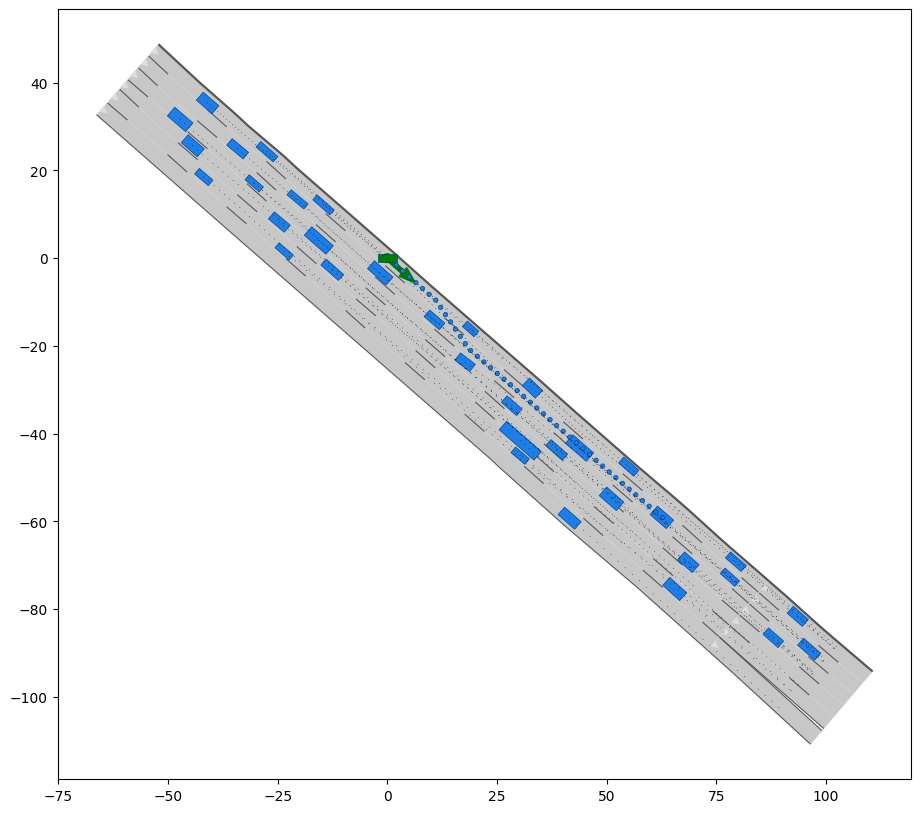

Failed unexpectedly


In [6]:
for i in range(100):
      # print("loop: ", i)
      # Run Frenet planner
      result_x, result_y, speeds, ix, iy, iyaw, d, s, speeds_x, \
                  speeds_y, misc, costs, success = fot_wrapper.run_fot(initial_conditions, hyperparameters)
                  
      # Convert Frenet output (result_x, result_y, velocity, velocity_y) to PMState object (Point Mass Vehicle Model)
      if i == 0:
            states_list: List[List[PMState]] = [[PMState(time_step=j, position=np.array([result_x[j], result_y[j]]),\
                                                velocity=speeds_x[j], velocity_y=speeds_y[j])] for j in range(len(result_x[:LEN_DRAW]))]
      else:
            states_list: List[List[PMState]] = [[PMState(time_step=states_list[LEN_EXC-1][0].time_step+1+j, position=np.array([result_x[j], result_y[j]]),\
                                                velocity=speeds_x[j], velocity_y=speeds_y[j])] for j in range(len(result_x[:LEN_DRAW]))]
      
      # Convert the list of PMstates to CommonRoad trajectory (full trajectory to draw it and a shorter one to excute it)
      full_trajectory = create_trajectory_from_list_states(states_list)
      excuted_trajectory = create_trajectory_from_list_states(states_list[:LEN_EXC])
      # print(misc)
      # print("ix: ", ix, "\n\n", "iy: ", iy, "\n\n", "iyaw: ", iyaw, "\n\n")
      # print("ix: ", d, "\n\n")
      # print("result_x: ", result_x[0], "\nresult_y: ", result_y[0], "\n")
      
      # for state in excuted_trajectory.state_list:
      #       print(state)
      
      # Visualize the scenario and trajectories
      visualize_solution(scenario = scenario, 
                         planning_problem_set = planning_problem, 
                         drawn_trajectory = full_trajectory, 
                         excuted_trajectory = excuted_trajectory,
                         waypoints = w, 
                         t_s = i)
      
      if success:
            # If planning suceeded, check if goal was reached. If true, break the planning loop
            if np.abs(result_x[LEN_EXC-1] - goal_pos[0]) < EPS and np.abs(result_y[LEN_EXC-1] - goal_pos[1]) < EPS:
                print("Goal Reached")
                break
            
            # Parse initial conditions again for the next time step
            initial_conditions['pos'] = np.array([result_x[LEN_EXC-1], result_y[LEN_EXC-1]])
            initial_conditions['vel'] = np.array([speeds_x[LEN_EXC-1], speeds_y[LEN_EXC-1]])
            # initial_conditions['pos'] = np.array([result_x[0], result_y[0]])
            # initial_conditions['vel'] = np.array([speeds_x[0], speeds_y[0]])
            initial_conditions['ps'] = misc['s']
            # initial_conditions['obs'] = np.array(parser.parse_obstacles(time_step=(i+1)*LEN_EXC))
            initial_conditions['vel'] = np.array([speeds_x[LEN_EXC-1], speeds_y[LEN_EXC-1]])
            initial_conditions['obs'] = np.array([])
            # initial_conditions['obs'] = np.array(parser.parse_obstacles(time_step=i+1))
            # obs = initial_conditions['obs']
            # print(obs)
            # print(costs)
      else:
            print("Failed unexpectedly")
            break
